# InsightForge AI — Corporate Insights Agent
Submission Notebook

“Forging insights from raw data with intelligent planning.”

**Author: Muhammad Ikram Hafeez**

**Track: Enterprise Agents**

In [1]:
import os
import json
import re
import time
import textwrap
import warnings
from typing import List, Dict, Any

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb

from openai import OpenAI
import google.generativeai as genai

# Load API keys
OPENAI_KEY = os.environ.get("OPENAI_API_KEY")
GEMINI_KEY = os.environ.get("GEMINI_API_KEY")

if not OPENAI_KEY:
    raise ValueError("OPENAI_API_KEY is not set in your environment.")

client = OpenAI(api_key=OPENAI_KEY)

# Gemini config
if GEMINI_KEY:
    genai.configure(api_key=GEMINI_KEY)

OPENAI_MODEL = "gpt-4o-mini"
GEMINI_MODEL = "gemini-2.0-flash"


In [2]:
def generate_synthetic_sales(n_days=180, n_customers=600):
    rng = np.random.default_rng(42)
    dates = pd.date_range(end=pd.Timestamp.today(), periods=n_days)

    products = ["Alpha","Beta","Gamma","Delta"]
    regions = ["North","South","East","West"]
    channels = ["Online","Retail","Partner"]

    rows=[]
    for d in dates:
        for _ in range(rng.integers(10,30)):
            product = rng.choice(products)
            region = rng.choice(regions)
            channel = rng.choice(channels)
            units = int(abs(rng.normal(5,2))+1)
            price = float(20 + rng.normal(0,5))
            revenue = round(units*price,2)
            cid = f"C{rng.integers(1,n_customers):05d}"
            rows.append([d.date(),product,region,channel,units,price,revenue,cid])

    return pd.DataFrame(rows, columns=["date","product","region","channel","units","price","revenue","customer_id"])

GLOBAL_DF = generate_synthetic_sales()
GLOBAL_DF.head()


,date,product,region,channel,units,price,revenue,customer_id
0,2025-06-02,Delta,East,Retail,7,24.702824,172.92,C00121
1,2025-06-02,Alpha,East,Partner,6,18.418787,110.51,C00308
2,2025-06-02,Alpha,West,Retail,7,23.888960,167.22,C00469
3,2025-06-02,Gamma,South,Partner,6,15.703538,94.22,C00056
4,2025-06-02,Gamma,West,Online,7,19.750370,138.25,C00099


In [3]:
def sql_tool(query: str) -> pd.DataFrame:
    con = duckdb.connect()
    con.register("sales", GLOBAL_DF)
    try:
        df = con.execute(query).fetchdf()
    except Exception as e:
        raise RuntimeError(f"Bad SQL:\n{query}\n\nError: {e}")
    con.close()
    return df


def plot_tool(kind: str, df: pd.DataFrame, x=None, y=None, title=None):
    plt.figure(figsize=(8,4))

    # fallback mappings
    if y not in df.columns:
        if "revenue" in df.columns:
            warnings.warn(f"y={y} missing, using revenue")
            y = "revenue"
        else:
            raise ValueError(f"No valid y column: {y}")

    if kind == "line":
        if x not in df.columns:
            if "date" in df.columns:
                x = "date"
        plt.plot(df[x], df[y])

    elif kind == "bar":
        if x not in df.columns:
            raise ValueError(f"x column {x} missing for bar plot")
        agg = df.groupby(x)[y].sum().sort_values(ascending=False)
        agg.plot.bar()

    plt.title(title)
    plt.tight_layout()
    plt.show()


In [4]:
class SimpleMemory:
    def __init__(self):
        self.docs = []

    def add(self, doc_id, text, meta=None):
        self.docs.append({"id": doc_id, "text": text, "meta": meta or {}})


In [5]:
COLUMNS = ["date","product","region","channel","units","price","revenue","customer_id"]

PLANNER_PROMPT = f"""
You plan analysis for a dataset with EXACT columns:

{COLUMNS}

RULES:
- ALWAYS use only these columns.
- NEVER use: product_name, product_id, sales, total_sales, amount.
- ALWAYS alias sums as: SUM(revenue) AS revenue
- ALWAYS output JSON ONLY (list of steps).
- Each step has: name, action (sql/plot/nlp), args.

Examples:

[
 {{"name": "rev_by_date", "action": "sql",
   "args": {{"query": "SELECT date, SUM(revenue) AS revenue FROM sales GROUP BY date ORDER BY date"}}}},
 {{"name": "plot_revenue", "action": "plot",
   "args": {{"kind": "line", "x": "date", "y": "revenue", "title": "Revenue Over Time"}}}}
]

Now create steps for the user goal.
User goal:
"""

def gpt_plan(goal: str):
    msg = PLANNER_PROMPT + goal
    res = client.chat.completions.create(
        model=OPENAI_MODEL,
        messages=[{"role":"user","content":msg}],
        response_format={"type":"json_object"}
    )
    data = json.loads(res.choices[0].message.content)
    return data if isinstance(data, list) else data["steps"]


In [6]:
def gemini_summarize(text: str):
    if not GEMINI_KEY:
        return "(Gemini key missing) " + text[:400]

    res = genai.GenerativeModel(GEMINI_MODEL).generate_content(
        "Summarize succinctly:\n" + text
    )
    return res.text


In [7]:
class AgentController:
    def __init__(self, memory, planner):
        self.memory = memory
        self.planner = planner

    def run(self, goal: str):
        plan = self.planner(goal)
        artifacts = []
        df_history = {}    # store df by step name
        last_df = GLOBAL_DF

        for step in plan:
            action = step["action"]
            args = step["args"]
            name = step["name"]

            # ---------------- SQL STEP ----------------
            if action == "sql":
                df = sql_tool(args["query"])
                df_history[name] = df
                last_df = df
                artifacts.append({"name": name, "type": "table", "data": df})

            # ---------------- PLOT STEP ----------------
            elif action == "plot":
                x = args.get("x")
                y = args.get("y")

                # 1. Try: use last SQL DF
                plot_df = last_df

                # 2. If last DF does not contain x → search for a DF that has it
                if x not in plot_df.columns:
                    for df_name, df in df_history.items():
                        if x in df.columns:
                            plot_df = df
                            break

                # 3. If still missing → fallback to GLOBAL_DF (should never happen)
                if x not in plot_df.columns:
                    warnings.warn(f"x={x} missing in all DFS. Using GLOBAL_DF.")
                    plot_df = GLOBAL_DF

                plot_tool(
                    kind=args["kind"],
                    df=plot_df,
                    x=x,
                    y=y,
                    title=args.get("title")
                )
                artifacts.append({"name": name, "type": "plot", "data": "(plot generated)"})

            # ---------------- NLP STEP ----------------
            elif action == "nlp":
                text = " ".join([a["name"] for a in artifacts])
                summary = gemini_summarize(text + "\nUser goal: " + goal)
                artifacts.append({"name": name, "type": "text", "data": summary})

        # ---------- FINAL SUMMARY ----------
        text_items = [a for a in artifacts if a["type"] == "text"]
        if text_items:
            final_summary = text_items[-1]["data"]
        else:
            context = "Artifacts: " + ", ".join([a["name"] for a in artifacts])
            final_summary = gemini_summarize(context)

        self.memory.add(f"run_{time.time()}", final_summary)
        return {"plan": plan, "artifacts": artifacts, "summary": final_summary}


In [8]:
memory = SimpleMemory()
agent = AgentController(memory, gpt_plan)


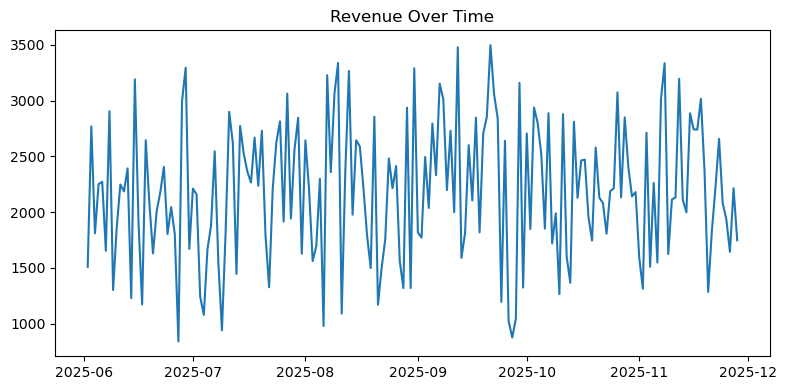

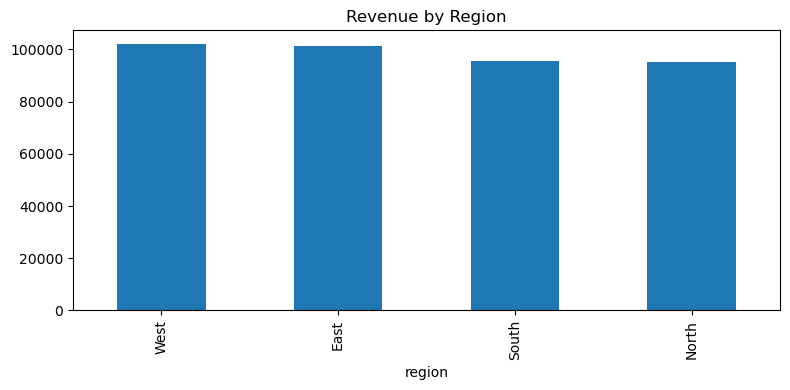

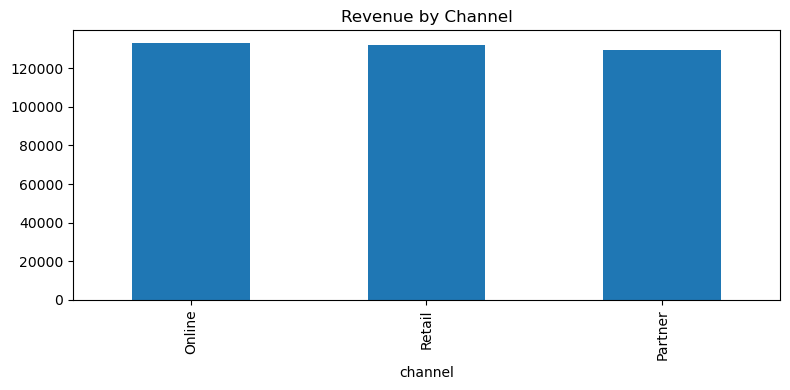


PLAN: [
  {
    "name": "rev_by_date",
    "action": "sql",
    "args": {
      "query": "SELECT date, SUM(revenue) AS revenue FROM sales GROUP BY date ORDER BY date"
    }
  },
  {
    "name": "plot_revenue",
    "action": "plot",
    "args": {
      "kind": "line",
      "x": "date",
      "y": "revenue",
      "title": "Revenue Over Time"
    }
  },
  {
    "name": "rev_by_region",
    "action": "sql",
    "args": {
      "query": "SELECT region, SUM(revenue) AS revenue FROM sales GROUP BY region ORDER BY revenue DESC"
    }
  },
  {
    "name": "plot_revenue_by_region",
    "action": "plot",
    "args": {
      "kind": "bar",
      "x": "region",
      "y": "revenue",
      "title": "Revenue by Region"
    }
  },
  {
    "name": "rev_by_channel",
    "action": "sql",
    "args": {
      "query": "SELECT channel, SUM(revenue) AS revenue FROM sales GROUP BY channel ORDER BY revenue DESC"
    }
  },
  {
    "name": "plot_revenue_by_channel",
    "action": "plot",
    "args": {
      

In [10]:
for p in [
    "Show revenue trends over time and identify growth drivers.",
    "What are the top products and best regions?"
]:
    out = agent.run(p)
    print("\nPLAN:", json.dumps(out["plan"], indent=2))
    print("\nSUMMARY:", out["summary"])
